In [17]:
from earthdata import Auth, DataCollections, DataGranules, Store # Used to ingest data from NSIDC
import geopandas as gpd # Used to subset regions using shapefile
import rioxarray as rx # Used to read raster data from hdf5 files


In [3]:
# Set working directories (local)

data_loc = "/home/jovyan/data/"

In [4]:
# Authenticate Earthdata credentials

auth = Auth().login(strategy='netrc')
if auth.authenticated is False:
    auth = Auth().login(strategy='interactive')

You're now authenticated with NASA Earthdata Login


# Step 1: Subset the Antarctica Ice Boundaries for a given region [Totten Basin]
**Following get-measures.ipynb from lbird**

0    POLYGON ((-1604213.024 911528.811, -1603107.44...
1    POLYGON ((-680809.736 1356261.688, -680579.602...
2    POLYGON ((-650479.108 590441.379, -644265.131 ...
3    POLYGON ((-549906.633 1305863.952, -572323.238...
4    POLYGON ((-418449.622 1964493.872, -417441.371...
Name: geometry, dtype: geometry


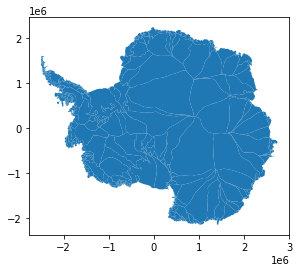

In [5]:
bd = gpd.read_file(data_loc+"/boundaries/IceBoundaries_Antarctica_v02.shp")
# Plot shapefile to make sure it as expected
bd.plot()

# 'Geometry' can be extracted - here, we print out the head of the geometry field
print(bd['geometry'].head())

,NAME,Regions,Subregions,TYPE,Asso_Shelf,geometry
40,Totten,East,Cp-D,GR,Totten,"POLYGON ((2239414.251 -1154868.625, 2238375.56..."


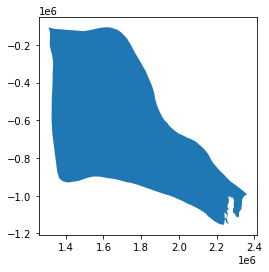

In [6]:
# Isolated only grounded ice (GR) for the Totten basin
tot = bd[(bd["NAME"] == "Totten") & (bd["TYPE"] == "GR")]

# Plot the Totten subset
tot.plot()

# View tot to make sure it is as expected
tot

# Subset BedMachineAntarctica raster and Grounding Line shapefile to a given region

BedMachineAntarctica CRS:  PROJCS["unnamed",GEOGCS["unknown",DATUM["unnamed",SPHEROID["Spheroid",6378273,298.27940504282]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-71],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["unknown",1],AXIS["Easting",NORTH],AXIS["Northing",NORTH]]
Tot shapefile CRS:  epsg:3031


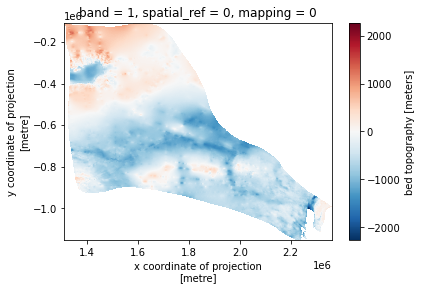

In [18]:
## Clip Tot basin bedrock topography: use drainage basin outline shapefile to clip the bedmachine gridded/raster file

ds=rx.open_rasterio(data_loc+"BedMachineAntarctica_2019-11-05_v01.nc", variable = "bed")

# Double check the crs of BedMachineAntarctica and drainage basin shapefile before clipping
print(f"BedMachineAntarctica CRS: ", ds.bed.rio.crs)
print(f"Tot shapefile CRS: ", tot.crs)

ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
ds.rio.write_crs("EPSG:3031", inplace=True)
Bed_tot = ds.rio.clip(tot.geometry, tot.crs)

Bed_tot_masked = Bed_tot.where(Bed_tot['bed'] != -9999.) # Replace -9999. with nan
Bed_tot_masked['bed'].plot()

## Save a local copy as a raster or netcdf
# Bed_tot.bed.rio.to_raster(data_loc+'Tot_BedMachineAntarctica.tif')
# Bed_tot.to_netcdf(data_loc+'Tot_BedMachineAntarctica.nc')

Grounding line CRS:  epsg:3031


<AxesSubplot:>

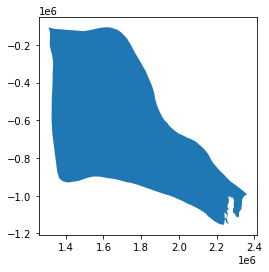

In [19]:
## Clip Grounding line using drainage basin shapefile

GL = gpd.read_file(data_loc+"/boundaries/GroundingLine_Antarctica_v02.shp")
print(f"Grounding line CRS: ", GL.crs)

GL_tot = gpd.clip(GL, tot) # Switch GL and tot to if need to use grounding line to clip tot shapefile
GL_tot.plot()

## Save a local copy
# GL_tot.to_file(data_loc+"GL_tot.shp", driver='ESRI Shapefile')